In [44]:
1+1

2

In [45]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from IPython.display import clear_output
import cv2
from torchvision import transforms
import copy
clear_output() 

In [46]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [47]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

LEARNING_RATE = 3e-4
BATCH_SIZE    = 8 #16 # 64
NUM_EPOCHS    = 10

IMAGE_HEIGHT  = 384  
IMAGE_WIDTH   = 384

MODEL_PATH = '/kaggle/working/model_jew_mask_13.05.2023.md'

INPUT_TRANSPARENT_DIR = '/kaggle/input/jewellery/raw_data_all/raw_data_all'
# IMAGE_DIR = '/kaggle/working/images/'
# MASK_DIR = '/kaggle/working/masks/'

REAL_PATH = '/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data'
ROCK_PAPER_SCISSORS_PATH = '/kaggle/input/rock-paper-scissors-dataset/train'
AAA_PATH  = '/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images'

K_RATIO = 2

cuda


## Случайное изображение из датасета объектов

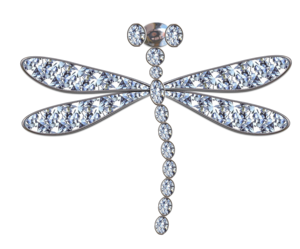

In [48]:
image_path = '/kaggle/input/jewellery/raw_data_all/raw_data_all/' + random.choice(os.listdir('/kaggle/input/jewellery/raw_data_all/raw_data_all'))
image = Image.open(image_path)#.convert('RGBA')#.getdata()
image

In [49]:
mask = image.getchannel(3)

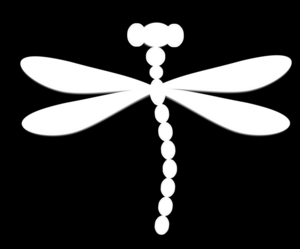

In [50]:
mask

In [51]:
def generate_background(w : int, h : int, lighten_range = [0.05, 0.95], amount = 1):
    '''
    Создает размытый фон, поверх которого можно накладывать изображение
    :param h: высота фона
    :param w: ширина фона
    :param lighten_range: задает тон
    :param amount: задает зернистость    
    :return: изображение типа Image формата RGBA размером (w, h)    
    '''
    white_list = np.zeros((h,w,3))
    max_col = 255

    amount = 1
    # add salt
    nb_salt = np.ceil(amount * white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in white_list.shape]
    white_list[coords] = 0

    # add pepper
    nb_pepper = np.ceil(amount* white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in white_list.shape]
    white_list[coords] = 1

    lighten = np.array([random.uniform(*lighten_range) for i in range(3)]) 

    white_list = 1-(1-white_list)*lighten

    white_list = Image.fromarray((white_list * max_col).astype(np.uint8))
    white_list = white_list.filter(ImageFilter.GaussianBlur(5))    

    
    draw = ImageDraw.Draw(white_list)
    
    if random.random() > 0.25:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            draw.rectangle((x1, y1, x2, y2), fill=color1, outline=color2)
        
    if random.random() > 0.75:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            width1 = random.randint(0, 20)
            draw.line((x1, y1, x2, y2), fill=color1, width=width1)               
        
    if random.random() > 0.75:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            draw.ellipse((x1, y1, x2, y2), fill=color1, outline=color2)       
        
    white_list = white_list.filter(ImageFilter.GaussianBlur(1))    

    
    return white_list

## Пример генерации фона

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


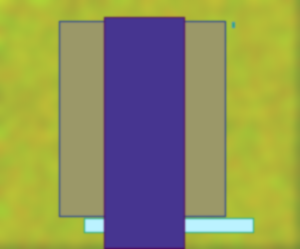

In [52]:
background = generate_background(*image.size)
background

In [53]:
def get_real_background(w:int, h:int):
    '''
    Создает фон, из датасетов реальных картинок, среди которых могут быть
    - комнаты с интерьером
    - руки
    :param w: ширина изображения
    :param h: высота изображения        
    :return: изображение типа Image формата RGB размером (w, h)   
    '''
    
    if random.random() > 0.5:
        path = REAL_PATH
    else:
        path = os.path.join(ROCK_PAPER_SCISSORS_PATH, random.choice(['paper', 'rock', 'scissors']) )
        
                
    real_images_list = os.listdir(path)    
    image_name = random.choice(real_images_list)   
    img_path = os.path.join(path, image_name)            
    image = Image.open(img_path)
            
    image = image.resize((w, h))      
    return image 

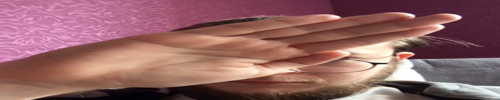

In [54]:
get_real_background(500,100)

In [55]:
def add_background(image, k=0):
    '''
    Накладывает изобрежание image на случайный фон, который может быть или сгенерированным, или реальным.
    :param image: изображение типа PIL Image
    :param k: во сколько раз фон больше изображения image       
    :return: изображение типа Image формата RGB того же размера, что и image
    '''    

    w0 = image.size[0]
    h0 = image.size[1]
              
    w = int((k * random.random()+1) * w0)
    h = int((k * random.random()+1) * h0)   
 
    w_shift = int((w - w0) * random.random())
    h_shift = int((h - h0) * random.random())  
    
    image_size = w, h
    shift = (w_shift, h_shift)

    
    if random.random() > 0.66:
        output = generate_background(*image_size)
    else:
        output = get_real_background(*image_size)
        
    output = output.convert('RGBA')
    
    n = np.array(output)
    n[:,:,3] = 0
    output = Image.fromarray(n)
    
    output.paste(image, shift, image)
    
    return output

In [56]:
def get_box_from_rgba(image):
    mask = np.array(image.getchannel(3)) >= 125
    
    ax = np.where( mask.max(axis=0) == True)[0]   
    x0, x1 = min(ax), max(ax)
    ax = np.where( mask.max(axis=1) == True)[0]  
    y0, y1 = min(ax), max(ax)       
    
    return x0, y0, x1, y1

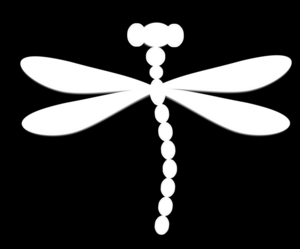

In [57]:
image.getchannel(3)

In [58]:
image = add_background(image, k=K_RATIO)

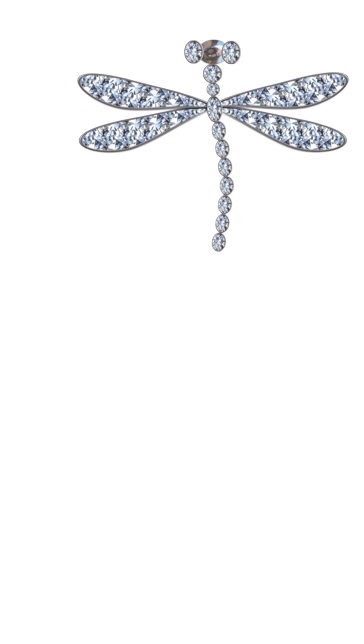

In [59]:
image

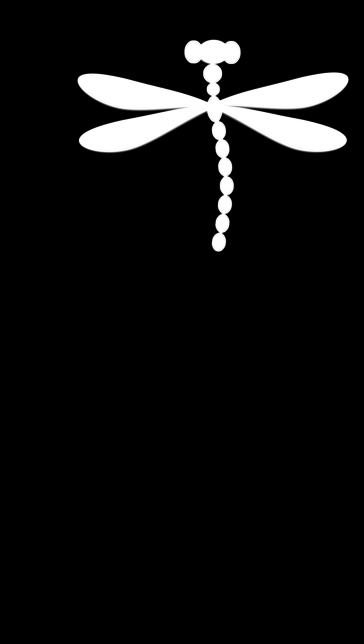

In [60]:
image.getchannel(3)

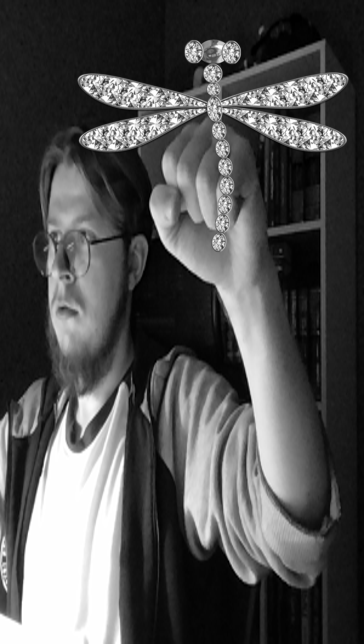

In [61]:
image.getchannel(1)

In [62]:
def draw_box_on_image(image, x0, y0, x1, y1, color='green'):
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box

In [63]:
def draw_box_on_image_multi(image, xy, color='green'):
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    
    for data in xy:
        x0, y0, x1, y1 = data[0],data[1],data[2],data[3]
        
        draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box  

In [64]:
def draw_image_with_box(image):
    x0, y0, x1, y1 = get_box_from_rgba(image)       
    return draw_box_on_image(image, x0, y0, x1, y1)

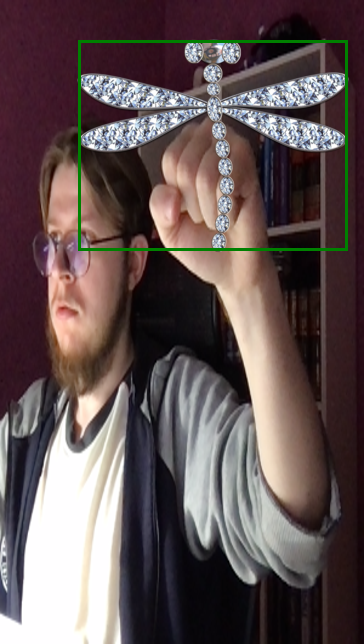

In [65]:
draw_image_with_box(image).convert('RGB')

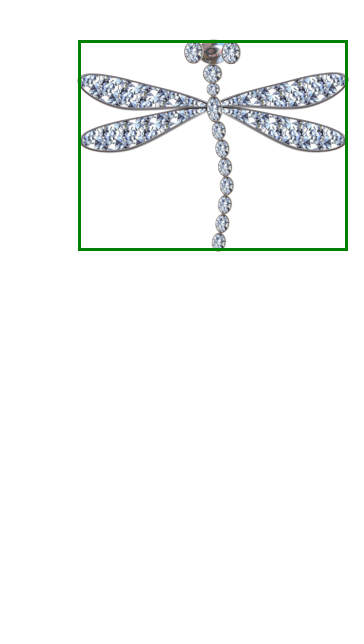

In [66]:
draw_image_with_box(image)

In [67]:
test_transform = torch.nn.Sequential(    
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),    
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
    )    


resize_transform = torch.nn.Sequential(    
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),    
    )    


def train_transform(image0, segmentation0):    
    image = TF.to_tensor(image0)
    segmentation = TF.to_tensor(segmentation0)
    
    if random.random() > 0.5:
        angle = random.random()*360
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle, interpolation=transforms.InterpolationMode.NEAREST, fill=0)        
    
    image = TF.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    segmentation = TF.resize(segmentation, [IMAGE_HEIGHT, IMAGE_WIDTH], interpolation=transforms.InterpolationMode.NEAREST)       
    
    if random.random() > 0.7:        
        image = TF.hflip(image)
        segmentation = TF.hflip(segmentation)

    original = image         
            
    if random.random() > 0.7:        
        image = TF.adjust_hue(image, 0.2-0.4*(random.random())   )
             
    if random.random() > 0.7:        
        image = TF.adjust_contrast(image, 0.8+0.4*(random.random())  )

    norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
    image =  norm(image) 

    segmentation = segmentation.detach().cpu().numpy()
#     segmentation = segmentation.squeeze(0) < 0.999   

    try:
        segmentation = segmentation.squeeze(0)
    except:
        pass
    segmentation = segmentation > segmentation.mean()
    
    ax = np.where( segmentation.max(axis=0) == True)[0]      
    if len(ax) == 0:
        x0, x1 = 0, IMAGE_WIDTH        
    else:
        x0, x1 = min(ax), max(ax)
        
    ax = np.where( segmentation.max(axis=1) == True)[0]          
    if len(ax) == 0:
        y0, y1 = 0, IMAGE_HEIGHT        
    else:
        y0, y1 = min(ax), max(ax)
       
    return original, image, x0, y0, x1, y1, segmentation.astype(int)

## Проверка работы train_transform

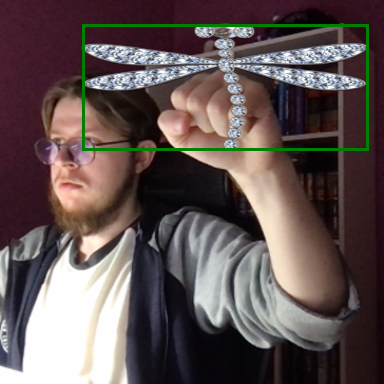

In [68]:
image_main = image.convert('RGB')
mask0 = image.getchannel(3)

original, i, x0, y0, x1, y1, mask = train_transform(image_main, mask0)

transform = transforms.ToPILImage()
img = transform(original)

show_box = copy.copy(img)
draw=ImageDraw.Draw(show_box)
draw.rectangle([(x0, y0),(x1, y1)],outline="green", width=3)
show_box    

In [69]:
x0, y0, x1, y1,

(82, 24, 368, 150)

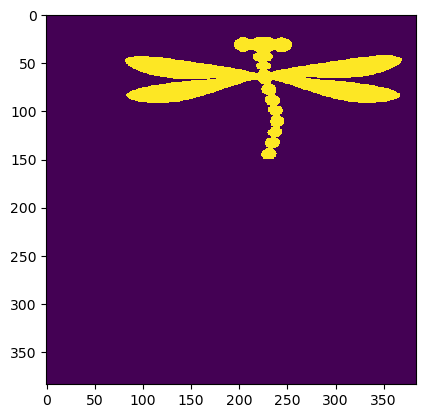

In [70]:
plt.imshow(mask, interpolation='nearest')
plt.show()

In [71]:
class SegmentationDataset(Dataset):
    def __init__(self, dir_images, is_train='train', transform=test_transform):
        self.dir_images  = dir_images
        self.transform  = transform
        self.is_train = is_train       
        self.images = os.listdir(dir_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path_image = os.path.join(self.dir_images, self.images[index])   
        image = Image.open(img_path_image)
        
        if self.is_train in ['train']:

            image = add_background(image, k=K_RATIO)
            mask = image.getchannel(3)

            image_main = image.convert('RGB')

            clean_image, aug_image, x0, y0, x1, y1, mask = self.transform(image_main, mask)
            return clean_image, aug_image, x0, y0, x1, y1, mask       
        
        else:
            image = TF.to_tensor(image)
            
            clean_image = resize_transform(image)
            
            image = self.transform(image)
            return clean_image, image

In [72]:
from PIL import ImageChops

In [73]:
class ManualDataset(Dataset):
    def __init__(self, dir_images, is_train='train', transform=test_transform):
        self.transform  = transform
        self.is_train = is_train   
        
        self.dir_images  = os.path.join(dir_images, 'images')     
        self.images = os.listdir(self.dir_images)
        self.dir_masks = os.path.join(dir_images, 'masks')  
        
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path_image = os.path.join(self.dir_images, self.images[index])   
        image = Image.open(img_path_image)
        
        mask_path_image = self.images[index].split('.')[0] + '.png'
        mask_path_image = os.path.join(self.dir_masks, mask_path_image)   
        mask = Image.open(mask_path_image).getchannel(0)
        mask = ImageChops.invert(mask)
        
        if self.is_train in ['train']:

            image_main = image.convert('RGB')

            clean_image, aug_image, x0, y0, x1, y1, mask = self.transform(image_main, mask)
            return clean_image, aug_image, x0, y0, x1, y1, mask       
        
        else:
            image = TF.to_tensor(image)
            
            clean_image = resize_transform(image)
            
            image = self.transform(image)
            return clean_image, image

In [107]:
# train_ds = SegmentationDataset(INPUT_TRANSPARENT_DIR, is_train='train', transform=train_transform)
train_ds = ManualDataset('/kaggle/input/jewellery/images_manual/images_manual', is_train='train', transform=train_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

## Проверка работы DataLoader

In [75]:
iters = next(iter(train_loader))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


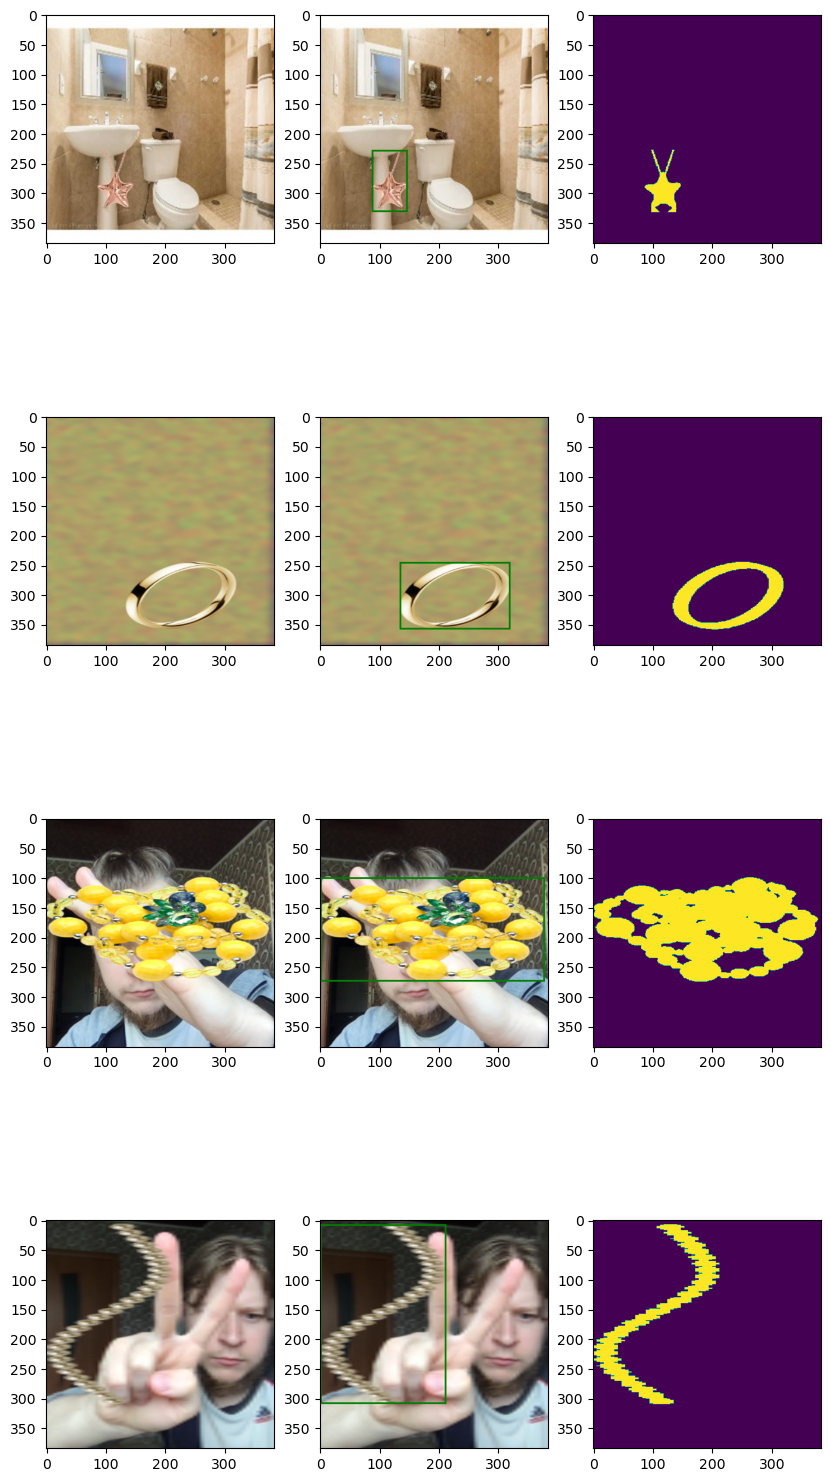

In [76]:
clean_image, aug_image, x0, y0, x1, y1, mask = iters

transform = transforms.ToPILImage()
rows = 4
_, ax = plt.subplots(rows, 3, figsize=(10,5*rows))
for k in range(rows):
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])    
    s = draw_box_on_image(q, x0[k], y0[k], x1[k], y1[k])    
    ax[k][1].imshow(s)      
    
    ax[k][2].imshow(mask[k])   

## Импорт модели

In [77]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
import math

In [78]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [79]:
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

In [80]:
model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)




In [81]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# lr_scheduler = None


In [82]:
def plot_progress(losses_dict, text='', size=(5, 5)):    
    clear_output(True)    
    plt.figure(figsize=size)
    
    for i, v in losses_dict.items():        
        x_array = range(len(v))    
        plt.plot(x_array, v, label = i)
        
    plt.ylim((None,1))
    plt.legend()
    plt.grid()
    
    if text != '':
        plt.text (0.05*x_array[-1],0.95*max(v), text)#, horizontalalignment='left')
    
    plt.show()

In [108]:
# Helper function for training for 1 epoch
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()

    start_time = time.time()
    
    length = len(data_loader)
    
    for i, data in enumerate(data_loader):
        
        clean_image_, image_, x0_, y0_, x1_, y1_, mask_ = data

        targets = []
        for j in range(len(clean_image_)):
            targets.append({'boxes': [[x0_[j], y0_[j], x1_[j], y1_[j]]],
                    'labels': [1],
                    'masks' : mask_[j].unsqueeze(0),
                   }
            )
                        
        images = list(image.to(device) for image in image_)

        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
                        
        loss_dict = model(images, targets)
        
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        # Print performance statistics
        batch_time = time.time()
        speed = (i+1)/(batch_time-start_time)
        
        history['losses'].append(loss_value)
        
        plot_progress(history, text='')

        print("------------------ Training Epoch {} ------------------".format(iepoch+1))        
        print(f'step {i+1}/{length}')
        print('[%5d] loss: %.3f, speed: %.2f' %
              (i, loss_value, speed))
                        
        lr_rate_current = optimizer.param_groups[-1]['lr']
        print(f'learing rate {lr_rate_current}')

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            break
            
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()

In [109]:
def train_all_epochs():
    global history
    global iepoch

    history = {'losses' : []}

    # Train the model for 1 epoch
    num_epochs = 30

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        iepoch = epoch
        
        print("------------------ Training Epoch {} ------------------".format(epoch+1))
        train_one_epoch(model, optimizer, train_loader, DEVICE)
        torch.save(model.state_dict(), MODEL_PATH)
        # --- Insert Testing Code Here ---

    print('Finished Training')

def load_model():
    name = '/kaggle/input/jewellery/models/model_jew_mask_13.05.2023.md'
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))

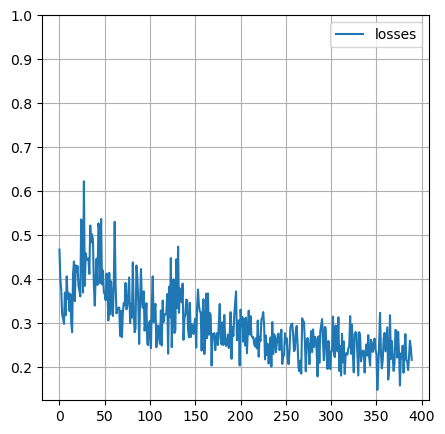

------------------ Training Epoch 30 ------------------
step 13/13
[   12] loss: 0.216, speed: 0.89
learing rate 7.202999999999997e-05
Finished Training


In [111]:
train_all_epochs()
# load_model()

## Проверка на обучающем датасете

In [112]:
def clean_image_with_mask(image):
    image = np.array(image)
    
    image[:,:,3] = (image[:,:,3] / 255.0+0.1).round()*255
    
    return Image.fromarray(image)

In [113]:
model.eval()
print()

In [114]:
iters = next(iter(train_loader))

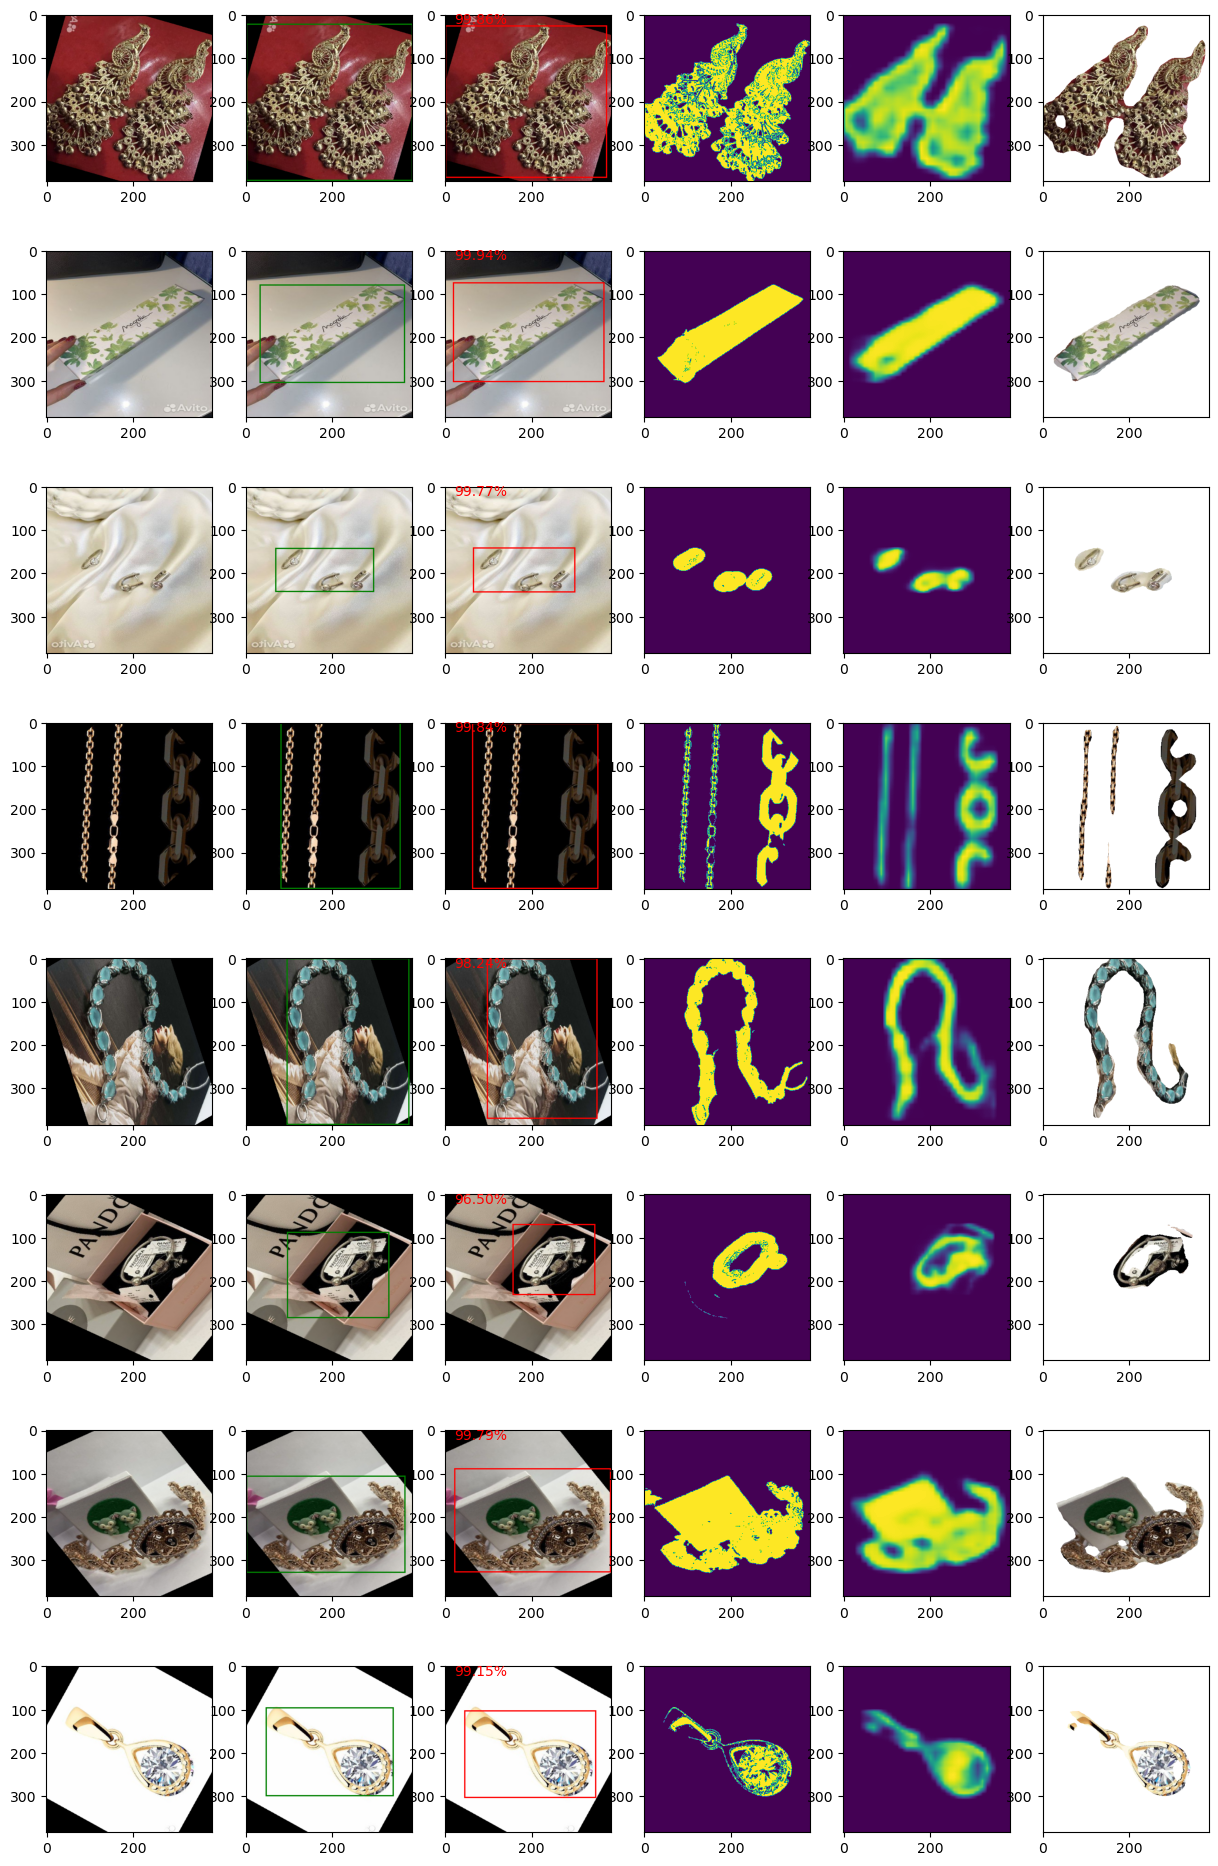

In [115]:
clean_image, aug_image, x0, y0, x1, y1, mask = iters

aug_image = list(image.to(DEVICE) for image in aug_image)    
predictions = model(aug_image)


transform = transforms.ToPILImage()
rows = len(clean_image)
_, ax = plt.subplots(rows, 6, figsize=(15,3*rows))
for k in range(rows):
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])
    
    s = draw_box_on_image(q, x0[k], y0[k], x1[k], y1[k])    
    ax[k][1].imshow(s)   
    
    
    pred_box = predictions[k]['boxes'][0].tolist()
    pred_score = predictions[k]['scores'][0].item()
    pred_mask = transform(predictions[k]['masks'][0])

    s = draw_box_on_image(q, *pred_box, color='red')    
    ax[k][2].text(20,20, f'{pred_score:.2%}', color='red')
    ax[k][2].imshow(s)      
    
    
    ax[k][3].imshow(mask[k])   
    
    ax[k][4].imshow(pred_mask)   
    
    q = copy.copy(clean_image[k])
    q = transform(q)
    q.putalpha(pred_mask)    
    
    q = clean_image_with_mask(q)
    
    ax[k][5].imshow(q)

In [116]:

#     for threshold in [0.8, 0.7, 0.6, 0.5]:
#         list_ind = np.where( pred_scores_numpy > 0.8)[0]
#         ind_max = len(list_ind)
#         if ind_max > 0:
#             break
#     if ind_max == 0:
#         ind_max = 1

#     pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
#     pred_boxs_good = pred_boxs_numpy[:ind_max]
 
#     s = draw_box_on_image_multi(q, pred_boxs_good, color='red')    
#     ax[k][2].text(20,20, f'{pred_score:.2%}', color='red')
#     ax[k][2].imshow(s)        
    
#     best_x0 = min([i[0] for i in pred_boxs_good])
#     best_y0 = min([i[1] for i in pred_boxs_good])
#     best_x1 = max([i[2] for i in pred_boxs_good])
#     best_y1 = max([i[3] for i in pred_boxs_good])
    
#     s = draw_box_on_image(q, best_x0, best_y0, best_x1, best_y1, color='red')    
#     ax[k][3].text(20,20, f'{pred_score:.2%}', color='red')
#     ax[k][3].imshow(s)     

## Проверка на датасете ААА

In [117]:
aaa_ds = SegmentationDataset(AAA_PATH, is_train='test', transform=test_transform)
aaa_loader = DataLoader(aaa_ds, batch_size=BATCH_SIZE, shuffle=True)

In [118]:
model.eval()
print()

In [119]:
iters = next(iter(aaa_loader))

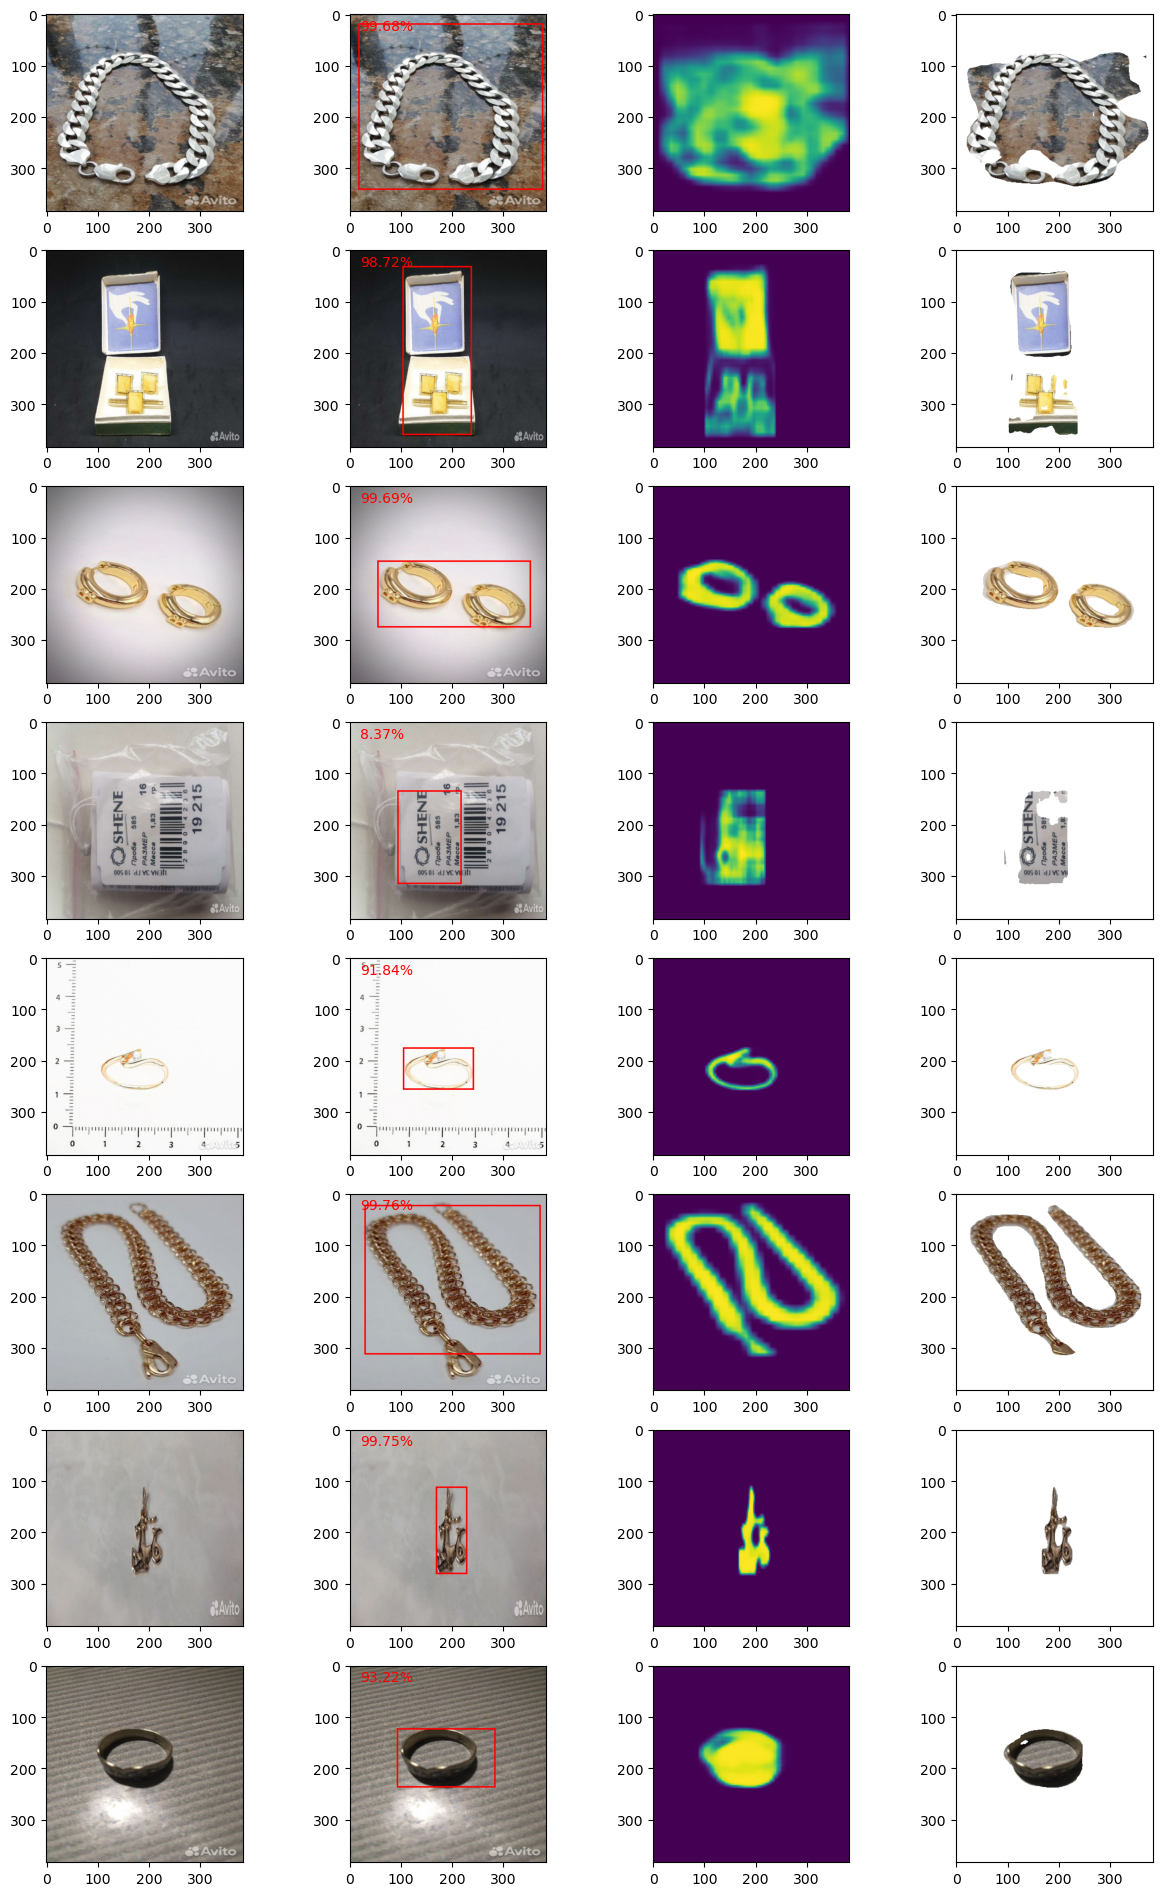

In [120]:
clean_image, aug_image = iters

aug_image = list(image.to(DEVICE) for image in aug_image)    
predictions = model(aug_image)


transform = transforms.ToPILImage()
rows = len(clean_image)
_, ax = plt.subplots(rows, 4, figsize=(15,3*rows))
for k in range(rows):
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])

    pred_box = predictions[k]['boxes'][0].tolist()
    pred_score = predictions[k]['scores'][0].item()
    pred_mask = transform(predictions[k]['masks'][0])

    s = draw_box_on_image(q, *pred_box, color='red')    
    ax[k][1].text(20,30, f'{pred_score:.2%}', color='red')
    ax[k][1].imshow(s)      
    
    
#     ax[k][2].imshow(mask[k])   
    
    ax[k][2].imshow(pred_mask)   
    
    q = copy.copy(clean_image[k])
    q = transform(q)
    q.putalpha(pred_mask)
    q = clean_image_with_mask(q)        
    
    ax[k][3].imshow(q)

In [121]:
predictions[k]['scores']

tensor([0.9322], device='cuda:0', grad_fn=<IndexBackward0>)

In [122]:
predictions[k]['boxes']

tensor([[ 91.0588, 123.4473, 283.0228, 238.5702]], device='cuda:0',
       grad_fn=<StackBackward0>)

In [99]:
#     pred_scores_numpy = pred_scores.detach().cpu().numpy()
    
#     for threshold in [0.8, 0.7, 0.6, 0.5]:
#         list_ind = np.where( pred_scores_numpy > 0.8)[0]
#         ind_max = len(list_ind)
#         if ind_max > 0:
#             break
#     if ind_max == 0:
#         ind_max = 1

#     pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
#     pred_boxs_good = pred_boxs_numpy[:ind_max]
 
#     s = draw_box_on_image_multi(q, pred_boxs_good, color='red')    
#     ax[k][2].text(20,20, f'{pred_score:.2%}', color='red')
#     ax[k][2].imshow(s)        
    
#     best_x0 = min([i[0] for i in pred_boxs_good])
#     best_y0 = min([i[1] for i in pred_boxs_good])
#     best_x1 = max([i[2] for i in pred_boxs_good])
#     best_y1 = max([i[3] for i in pred_boxs_good])
    
#     s = draw_box_on_image(q, best_x0, best_y0, best_x1, best_y1, color='red')    
#     ax[k][3].text(20,20, f'{pred_score:.2%}', color='red')
#     ax[k][3].imshow(s)     

In [100]:
# np.array(pred_mask)

In [101]:
# def bigger_mask(mask):
#     mask = np.array(mask)
#     if mask.max() > 1:
#         mask = mask / 256.0
        
#     mask = mask > 0.5    
    
#     ax = np.where(mask.max(axis=0) == True)[0]      
#     if len(ax) == 0:
#         x0, x1 = 0, mask.shape[0] 
#     else:
#         x0, x1 = min(ax), max(ax)
        
#     ax = np.where(mask.max(axis=1) == True)[0]          
#     if len(ax) == 0:
#         y0, y1 = 0, mask.shape[1]       
#     else:
#         y0, y1 = min(ax), max(ax)
        
#     w = x1 - x0
#     h = y1 - y0
    
#     k = 0.1
    
#     x0 = max(x0 - k * w, 0)
#     x1 = min(x1 + k * w, mask.shape[0])
#     y0 = max(y0 - k * w, 0)
#     y1 = min(y1 + k * w, mask.shape[1])
        
    
#     return mask

In [102]:
# bigger_mask(pred_mask).max()